In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import copy
import folium

In [21]:
#CARGA DE DATOS
#Se reutiliza el código de carga de datos del proyecto anterior

def load_distance_time_dic(path):
    data = pd.read_csv(path)
    distance = {}
    time = {}
    for i in range(len(data)):
        origen = int(data.iloc[i, 0])
        destino = int(data.iloc[i, 1])
        distance[origen, destino] = float(data.iloc[i, 2])
        time[origen, destino] = float(data.iloc[i, 3])
    return distance, time
5
def load_vehicles(path):
    data = pd.read_csv(path)
    vehicles = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 0])
        capacity = int(data.iloc[i, 1])
        ran = float(data.iloc[i, 2])
        vehicles[id] = (capacity, ran)
    return vehicles

def load_demand(path):
    data = pd.read_csv(path)
    demand_dic = {}
    for i in range(len(data)):
        id = int(data.iloc[i, 1])
        demand = float(data.iloc[i, 2])
        demand_dic[id] = demand
    return demand_dic

def load_coordinates(depotsPath, clientsPath):
    coord = {}
    depot = pd.read_csv(depotsPath)
    client = pd.read_csv(clientsPath)
    for i in range(len(depot)):
        id = int(depot.iloc[i, 1])
        lat = float(depot.iloc[i, 3])
        long = float(depot.iloc[i, 2])
        coord[id] = [lat, long]
    for j in range(len(client)):
        id = int(client.iloc[j, 1])
        lat = float(client.iloc[j, 4])
        long = float(client.iloc[j, 3])
        coord[id] = [lat, long]
    return coord


In [22]:
distancia,time_dic = load_distance_time_dic('../Datos/casoBase.csv')
vehiculos = load_vehicles('../Datos/vehicles.csv')
demanda = load_demand('../Datos/clients.csv')
coord = load_coordinates('../Datos/depots.csv', '../Datos/clients.csv')
print(f"Distancia: {distancia}")
print(f"Vehiculos: {vehiculos}")
print(f"Demanda: {demanda}")
print(f"Coordenadas: {coord}")
print(f"Time: {time_dic}")



Distancia: {(1, 2): 27144.3, (1, 3): 17677.1, (1, 4): 13979.6, (1, 5): 26650.8, (1, 6): 22583.7, (1, 7): 18562.5, (1, 8): 24765.9, (1, 9): 23929.4, (1, 10): 27835.9, (1, 11): 33651.8, (1, 12): 31029.4, (1, 13): 16124.7, (1, 14): 21612.2, (1, 15): 10387.4, (1, 16): 27040.2, (1, 17): 33963.1, (1, 18): 26541.3, (1, 19): 20053.2, (1, 20): 21278.2, (1, 21): 13411.2, (1, 22): 27869.5, (1, 23): 24262.6, (1, 24): 11364.8, (1, 25): 30809.8, (2, 1): 30809.9, (2, 3): 14256.3, (2, 4): 19400.3, (2, 5): 1130.9, (2, 6): 12475.1, (2, 7): 11416.7, (2, 8): 16851.4, (2, 9): 13820.8, (2, 10): 7509.8, (2, 11): 7110.4, (2, 12): 10890.2, (2, 13): 24445.1, (2, 14): 7973.9, (2, 15): 20142.5, (2, 16): 1255.4, (2, 17): 7421.8, (2, 18): 4283.4, (2, 19): 9819.6, (2, 20): 15281.3, (2, 21): 23046.5, (2, 22): 21147.7, (2, 23): 5482.0, (2, 24): 21239.2, (2, 25): 4880.9, (3, 1): 18222.2, (3, 2): 12672.2, (3, 4): 6812.6, (3, 5): 12178.7, (3, 6): 14735.1, (3, 7): 8279.5, (3, 8): 8286.5, (3, 9): 16080.8, (3, 10): 15410.7,

In [54]:
# Parámetros
depot_id = 1  # depósito con demanda 0
pf = 15000
ft = 5000
cm = 700
gv = 0.411458

def evaluar_individuo(rutas, demanda, vehiculos, distancia, pf, ft, cm, gv):
    claves_vehiculos = list(vehiculos.keys())
    total_cost = 0
    for v_id, ruta in enumerate(rutas):
        if len(ruta) <= 2:
            continue
        cap_max, rango_max = vehiculos[claves_vehiculos[v_id]]
        carga = 0
        distancia_total = 0

        for i in range(len(ruta) - 1):
            a, b = ruta[i], ruta[i+1]
            distancia_total += distancia.get((a, b), 9999999)
            if b != depot_id:
                carga += demanda.get(b, 0)

        penalizacion = 0
        if carga > cap_max:
            penalizacion += 1e6 * (carga - cap_max)
        if distancia_total > rango_max:
            penalizacion += 1e6 * (distancia_total - rango_max)

        costo_vehiculo = gv*pf * distancia_total + ft + cm + penalizacion
        total_cost += costo_vehiculo
    return total_cost

def generar_poblacion_inicial(n_individuos, clientes, vehiculos):
    poblacion = []
    n_vehiculos = len(vehiculos)
    for _ in range(n_individuos):
        rutas = [[] for _ in vehiculos]
        clientes_copy = clientes[:]
        random.shuffle(clientes_copy)
        # Asignar cada cliente exactamente a un vehículo
        for idx, c in enumerate(clientes_copy):
            v_id = idx % n_vehiculos  # asignación round robin para mejor distribución
            rutas[v_id].append(c)
        # Agregar depósito al inicio y fin de cada ruta
        rutas = [[depot_id] + r + [depot_id] if r else [] for r in rutas]
        poblacion.append(rutas)
    return poblacion

def mutar(rutas):
    nuevas = copy.deepcopy(rutas)
    # Elegir dos vehículos distintos
    v1, v2 = random.sample(range(len(rutas)), 2)
    if len(nuevas[v1]) > 2:
        cliente = random.choice(nuevas[v1][1:-1])
        nuevas[v1].remove(cliente)
        # Insertar cliente en una posición aleatoria en v2, excepto el depósito final
        pos = random.randint(1, len(nuevas[v2]) - 1) if len(nuevas[v2]) > 0 else 1
        nuevas[v2].insert(pos, cliente)
    return nuevas

def cruzar(p1, p2):
    hijo = copy.deepcopy(p1)
    v = random.randint(0, len(p1) - 1)
    if len(p1[v]) > 2 and len(p2[v]) > 2:
        sub1 = p1[v][1:-1]
        sub2 = p2[v][1:-1]
        split = len(sub1) // 2
        nuevo = [depot_id] + sub1[:split] + sub2[split:] + [depot_id]
        # Para evitar duplicados/remover clientes fuera de esta ruta,
        # hacemos limpieza después del cruce
        hijo[v] = nuevo

        # Extraer clientes asignados en la nueva ruta
        asignados = set(nuevo[1:-1])

        # Eliminar estos clientes de otras rutas para evitar duplicados
        for i in range(len(hijo)):
            if i != v:
                hijo[i] = [depot_id] + [c for c in hijo[i][1:-1] if c not in asignados] + [depot_id]

        # Insertar los clientes que quedaron fuera en la ruta v de forma aleatoria
        todos_clientes = set(c for ruta in p1 for c in ruta[1:-1])
        fuera = todos_clientes - asignados
        for c in fuera:
            pos = random.randint(1, len(hijo[v]) - 1)
            hijo[v].insert(pos, c)
    return hijo

def nodos_no_asignados(rutas, clientes, depot_id):
    asignados = set()
    for ruta in rutas:
        asignados.update(n for n in ruta if n != depot_id)
    no_asignados = set(clientes) - asignados
    return no_asignados

def run_ga(distance, demand, vehicles, coord, n_generaciones=200, n_poblacion=50, elitismo=5, prob_mutacion=0.2):
    demanda[depot_id] = 0
    clientes = [c for c in demand.keys() if c != depot_id]
    poblacion = generar_poblacion_inicial(n_poblacion, clientes, vehicles)
    best_indiv = []
    for gen in range(n_generaciones):
        puntuaciones = [(evaluar_individuo(ind, demand, vehicles, distance, pf, ft, cm, gv), ind) for ind in poblacion]
        puntuaciones.sort(key=lambda x: x[0])
        best_indiv.append(puntuaciones[0][0])
        elite = [ind for (_, ind) in puntuaciones[:elitismo]]

        nueva_poblacion = elite[:]
        while len(nueva_poblacion) < n_poblacion:
            p1, p2 = random.choices(elite, k=2)
            hijo = cruzar(p1, p2)
            if random.random() < prob_mutacion:
                hijo = mutar(hijo)
            # Validar que no haya nodos sin asignar, si hay los añadimos manualmente
            faltantes = nodos_no_asignados(hijo, clientes, depot_id)
            if faltantes:
                # Añadir faltantes a rutas aleatorias
                for f in faltantes:
                    v_id = random.randint(0, len(vehicles) -1)
                    # Insertar antes del depósito final
                    hijo[v_id].insert(-1, f)
            nueva_poblacion.append(hijo)

        poblacion = nueva_poblacion

    mejor_coste, mejor_sol = min([(evaluar_individuo(ind, demand, vehicles, distance, pf, ft, cm, gv), ind) for ind in poblacion], key=lambda x: x[0])

    faltantes_final = nodos_no_asignados(mejor_sol, clientes, depot_id)
    if faltantes_final:
        print("Algunos nodos no fueron asignados en la mejor solución:", faltantes_final)
    else:
        print("Todos los nodos fueron asignados correctamente.")

    print("Mejor costo:", mejor_coste)
    return mejor_sol, best_indiv



In [30]:
def visualizar_rutas_folium(rutas, coord):
    # Crear mapa centrado en depósito o promedio de coordenadas
    lat_dep, lon_dep = coord[depot_id]
    m = folium.Map(location=[lat_dep, lon_dep], zoom_start=11, tiles='Cartodb Positron')

    colors = ['blue', 'green', 'cyan', 'magenta','olive', 'blue', 'orange', 'purple','red']
    icons = ['blue', 'green', 'lightblue', 'pink','lightgreen', 'blue', 'orange', 'darkpurple','red']

    for v, ruta in enumerate(rutas):
        if not ruta or len(ruta) < 2:
            continue

        # Construir lista de coordenadas para PolyLine: [(lat, lon), (lat, lon), ...]
        coords_ruta = [coord[n] for n in ruta]

        # Dibujar la ruta
        folium.PolyLine(
            coords_ruta,
            color=colors[v % len(colors)],
            weight=5,
            opacity=0.7,
            tooltip=f'Vehículo {v}'
        ).add_to(m)

        # Marcador inicio (depósito)
        folium.Marker(
            coords_ruta[0],
            popup="Inicio (Depósito)",
            icon=folium.Icon(color='black', icon='home')
        ).add_to(m)

        # Marcador fin de ruta
        folium.Marker(
            coords_ruta[-1],
            popup=f"Llegada Vehículo {v}",
            icon=folium.Icon(color=icons[v % len(icons)], icon='flag')
        ).add_to(m)

    return m


Todos los nodos fueron asignados correctamente.
Mejor costo: 568259416027.981


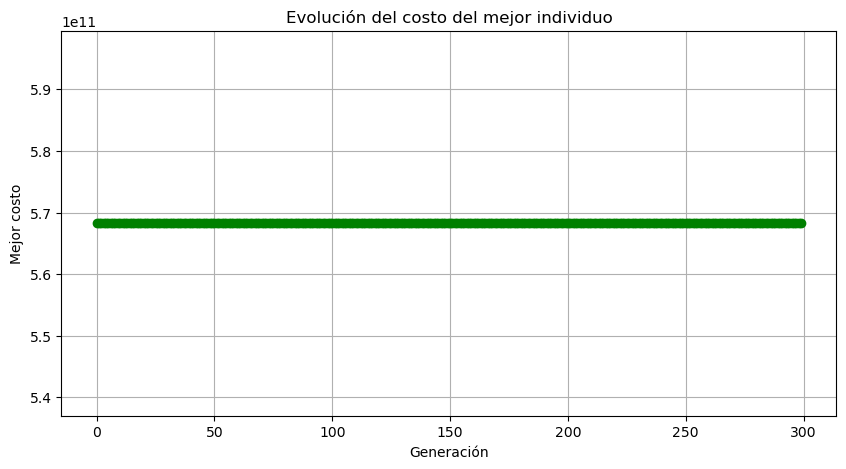

In [55]:
solucion, evol = run_ga(distancia, demanda, vehiculos, coord, n_generaciones=300, n_poblacion=50, elitismo=5, prob_mutacion=0.7)

def graficar_evolucion_costos(mejores_costos):
    plt.figure(figsize=(10, 5))
    plt.plot(mejores_costos, marker='o', color='green')
    plt.xlabel('Generación')
    plt.ylabel('Mejor costo')
    plt.title('Evolución del costo del mejor individuo')
    plt.grid(True)
    plt.show()

graficar_evolucion_costos(evol)
#mapa = visualizar_rutas_folium(solucion, coord)
#mapa

## Visualización y estadísticas

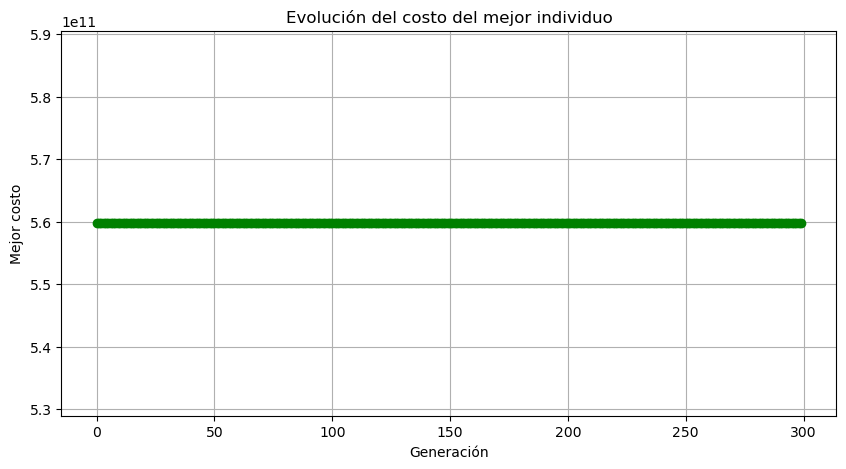

In [36]:
def graficar_solucion(rutas, coord, depot_id=1):
    colores = plt.cm.get_cmap('tab10', len(rutas))
    plt.figure(figsize=(10, 8))

    for idx, ruta in enumerate(rutas):
        if not ruta:
            continue
        puntos = [coord[n] for n in ruta]
        xs, ys = zip(*puntos)
        plt.plot(xs, ys, marker='o', label=f'Vehículo {idx}', color=colores(idx))

        for i, n in enumerate(ruta):
            plt.text(xs[i], ys[i], str(n), fontsize=9)

    plt.scatter(*coord[depot_id], c='red', s=100, label='Depósito')
    plt.title("Rutas de los vehículos")
    plt.legend()
    plt.grid()
    plt.show()

def evaluar_individuo(rutas, demanda, vehiculos, distancia, pf, ft, cm, gv, return_detalles=False):
    claves_vehiculos = list(vehiculos.keys())
    total_cost = 0
    detalles = []
    for v_id, ruta in enumerate(rutas):
        if len(ruta) <= 2:
            detalles.append(0)
            continue
        cap_max, rango_max = vehiculos[claves_vehiculos[v_id]]
        carga = 0
        distancia_total = 0

        for i in range(len(ruta) - 1):
            a, b = ruta[i], ruta[i+1]
            distancia_total += distancia.get((a, b), 9999999)
            if b != depot_id:
                carga += demanda.get(b, 0)

        penalizacion = 0
        if carga > cap_max:
            penalizacion += 1e6 * (carga - cap_max)
        if distancia_total > rango_max:
            penalizacion += 1e6 * (distancia_total - rango_max)

        costo_vehiculo = gv * pf * distancia_total + ft + cm + penalizacion
        total_cost += costo_vehiculo
        detalles.append(costo_vehiculo)

    return (total_cost, detalles) if return_detalles else total_cost

def graficar_costos_por_vehiculo(rutas, demanda, vehiculos, distancia, pf, ft, cm, gv):
    _, costos = evaluar_individuo(rutas, demanda, vehiculos, distancia, pf, ft, cm, gv, return_detalles=True)
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(costos)), costos, color='steelblue')
    plt.xlabel('Vehículo')
    plt.ylabel('Costo')
    plt.title('Costo por vehículo')
    plt.grid(True)
    plt.show()


def graficar_evolucion_costos(mejores_costos):
    plt.figure(figsize=(10, 5))
    plt.plot(mejores_costos, marker='o', color='green')
    plt.xlabel('Generación')
    plt.ylabel('Mejor costo')
    plt.title('Evolución del costo del mejor individuo')
    plt.grid(True)
    plt.show()

graficar_evolucion_costos(evol)

## Analisis de Escalabilidad

## Comparación son soluciones previas (Pyomo)